In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import functools

In [2]:
training_set = torchvision.datasets.FashionMNIST(
  root = './data/FashionMNIST',
  train=True,
  download=True,
  transform = transforms.Compose([
    transforms.ToTensor()
  ])
)

In [3]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = torch.nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=60)
        self.fc3 = torch.nn.Linear(in_features=60, out_features=10)

        #Operations
        self.maxpool2d2k2s = functools.partial(F.max_pool2d, kernel_size=2, stride=2)
        self.relu = F.relu
        self.softmax = F.softmax

    def forward(self, t):
        t = self.conv1(t)
        t = self.relu(t)
        t = self.maxpool2d2k2s(t)

        t = self.conv2(t)
        t = self.relu(t)
        t = self.maxpool2d2k2s(t)

        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = self.relu(t)

        t = self.fc2(t)
        t = self.relu(t)

        t = self.fc3(t)
        return t

In [4]:
def get_num_correct(predictions, labels):
    return torch.argmax(predictions, dim=1).eq(labels).sum().item()

In [7]:
new_network = Network()
data_loader = torch.utils.data.DataLoader(training_set, batch_size=100)
optimizer = optim.Adam(new_network.parameters(), lr=0.01)
NUM_EPOCHS = 10

In [8]:
for i in range(NUM_EPOCHS):
    total_loss = 0
    total_correct = 0
    loss_list = []
    for batch in data_loader:
        
        images, labels = batch

        predictions = new_network(images)
        loss = F.cross_entropy(predictions, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_correct += get_num_correct(predictions, labels)
        total_loss += loss.item()
        loss_list.append(loss.item())

    print("epoch: ", i,' loss: ', total_loss, ' correct: ', 
          total_correct)

epoch:  0  loss:  320.10553908348083  correct:  48038
epoch:  1  loss:  223.55850146710873  correct:  51754
epoch:  2  loss:  207.29799257218838  correct:  52293
epoch:  3  loss:  200.14671848714352  correct:  52542
epoch:  4  loss:  191.78789430856705  correct:  52812
epoch:  5  loss:  190.01214063167572  correct:  52904
epoch:  6  loss:  186.5267535597086  correct:  53018
epoch:  7  loss:  181.54046157747507  correct:  53206
epoch:  8  loss:  179.62509358674288  correct:  53314
epoch:  9  loss:  185.51415465772152  correct:  53160


In [9]:
def get_all_predictions(model, loader):
    all_predictions = torch.tensor([])
    for batch in loader:
        images, labels = batch
        predictions = model(images)
        all_predictions = torch.cat((all_predictions, predictions), 
                                    dim=0)
    return all_predictions

In [15]:
# prediction_loader = torch.utils.data.DataLoader(training_set, 
#                                                 batch_size=100)
# train_predictions = get_all_predictions(new_network, 
#                                         prediction_loader)

In [11]:
# train_predictions

tensor([[-25.7898, -17.0848, -21.0427,  ...,   4.8181, -16.4729,   9.9146],
        [ 19.4848, -12.1059,  -0.7508,  ..., -44.8961,  -6.6709, -53.2397],
        [  3.9191,   0.1640,  -2.8548,  ..., -18.6552,  -5.5271, -15.0113],
        ...,
        [  2.0490,  -2.5345,  -6.5799,  ..., -25.5222,  -5.0122, -24.6600],
        [  6.9794,  -4.9875,   0.6172,  ..., -17.0308,  -3.9612, -17.5064],
        [ -1.5706, -24.2059,  -4.2384,  ...,  -2.3281,  -2.8095,  -4.7609]],
       grad_fn=<CatBackward>)

In [12]:
# train_predictions.requires_grad

True

In [ ]:
# train_predictions.grad

In [ ]:
# train_predictions.grad_fn

In [ ]:
# it is best to turn grad off locally during testing of a network like below:

In [10]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(training_set, 
                                                batch_size=100)
    train_predictions = get_all_predictions(new_network, 
                                        prediction_loader)

In [ ]:
#same effect a before but turns the grad off everytime the function is run

@torch.no_grad()
def get_n_correct_predictionsedictions(model, loader):
    all_predictions = torch.tensor([])
    for batch in loader:
        images, labels = batch
        predictions = model(images)
        all_predictions = torch.cat((all_predictions, predictions), 
                                    dim=0)
    return all_predictions

In [11]:
n_correct_predictions = get_num_correct(train_predictions, training_set.targets)
print('accuracy: ', n_correct_predictions/len(training_set))

accuracy:  0.8832833333333333


In [16]:
stacked = torch.stack([training_set.targets, train_predictions.argmax(dim=1)], dim=1)

In [17]:
stacked.shape

torch.Size([60000, 2])

In [21]:
confusion_matrix = torch.zeros(10, 10, dtype=torch.int16)

In [22]:
for pair in stacked:
    i,j = pair
    confusion_matrix[i,j] += 1

In [23]:
confusion_matrix

tensor([[5656,    1,   83,   91,   14,    0,   94,    1,   60,    0],
        [  18, 5817,    2,  140,    5,    0,    9,    0,    9,    0],
        [  95,    3, 4733,   43,  917,    0,  173,    0,   36,    0],
        [ 165,    3,   17, 5556,  168,    0,   72,    0,   17,    2],
        [  15,    0,  269,  201, 5316,    0,  150,    0,   49,    0],
        [   0,    0,    1,    0,    0, 5644,    0,  225,   22,  108],
        [1611,    0,  618,  126,  835,    0, 2706,    0,  104,    0],
        [   0,    0,    0,    1,    0,   17,    0, 5868,    3,  111],
        [  19,    1,    7,   21,   17,    1,   12,    9, 5912,    1],
        [   1,    0,    0,    0,    0,    3,    1,  201,    5, 5789]],
       dtype=torch.int16)

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix_data = torch.tensor(
    confusion_matrix(
        training_set.targets, 
        train_predictions.argmax(dim=1)
    )
)

In [29]:
from plot_cm import plot_confusion_matrix

In [34]:
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)

In [39]:
[i for i in dir(confusion_matrix_data) if 'numpy' in i]

['numpy']

Confusion matrix, without normalization
[[5656    1   83   91   14    0   94    1   60    0]
 [  18 5817    2  140    5    0    9    0    9    0]
 [  95    3 4733   43  917    0  173    0   36    0]
 [ 165    3   17 5556  168    0   72    0   17    2]
 [  15    0  269  201 5316    0  150    0   49    0]
 [   0    0    1    0    0 5644    0  225   22  108]
 [1611    0  618  126  835    0 2706    0  104    0]
 [   0    0    0    1    0   17    0 5868    3  111]
 [  19    1    7   21   17    1   12    9 5912    1]
 [   1    0    0    0    0    3    1  201    5 5789]]


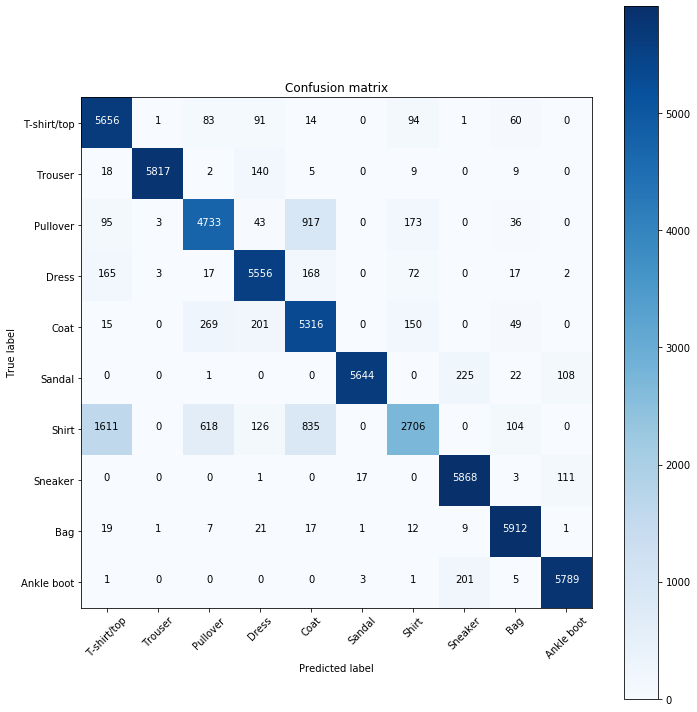

In [45]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix_data.numpy(), names, normalize=False)